# Training

In [24]:
import torch.nn as nn
import torch
from tqdm import tqdm
from vae_based_medical_image_generator.data import dataset
from torch.utils.data import DataLoader
from vae_based_medical_image_generator.model.vae import EncoderVAE, DecoderVAE, VariationalAutoencoder, vae_loss

# Define hyperparameters for training
img_channels = 1
feature_dim = 32*20*20
latent_dim = 100

batch_size = 32
lr = 1e-4
num_epochs = 10

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [25]:
# initialize the encoder and the decoder

encoder = EncoderVAE(img_channels, feature_dim, latent_dim) 
decoder = DecoderVAE(img_channels, feature_dim, latent_dim)
vae = VariationalAutoencoder(encoder, decoder, device).to(device)

# initialize optimizer
optimizer = torch.optim.Adam(vae.parameters(), lr=lr)

In [26]:
# initialize dataset
train_dataset = dataset.load_dataset(dataset_name="organamnist", split="train")
test_dataset  = dataset.load_dataset(dataset_name="organamnist", split="test")

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(dataset=test_dataset,  batch_size=batch_size, shuffle=False)

Using downloaded and verified file: /home/leon/.medmnist/organamnist.npz
Using downloaded and verified file: /home/leon/.medmnist/organamnist.npz


In [43]:
"""
Training the network for a given number of epochs
The loss after every epoch is printed
"""
training_losses = [] 

for epoch in range(num_epochs):
    with tqdm(train_loader, unit="batch") as tepoch:
        tepoch.set_description(f"Epoch {epoch}")

        loss_per_epoch = 0

        for data in tepoch:
            imgs, _ = data
            imgs = imgs.to(device)
            
            out, mu, logVar = vae(imgs)
            training_loss = vae_loss(imgs, out, mu, logVar) 

            loss_per_epoch += training_loss.item()

            optimizer.zero_grad()
            training_loss.backward()
            optimizer.step()

            # tepoch.set_postfix(loss=training_loss.item())  

        training_losses.append(loss_per_epoch/len(train_loader.dataset))

Epoch 1:  31%|███▏      | 340/1081 [00:02<00:05, 130.62batch/s]


KeyboardInterrupt: 

[-15740.096213419218, -15962.492746197333, -16153.175870600908]


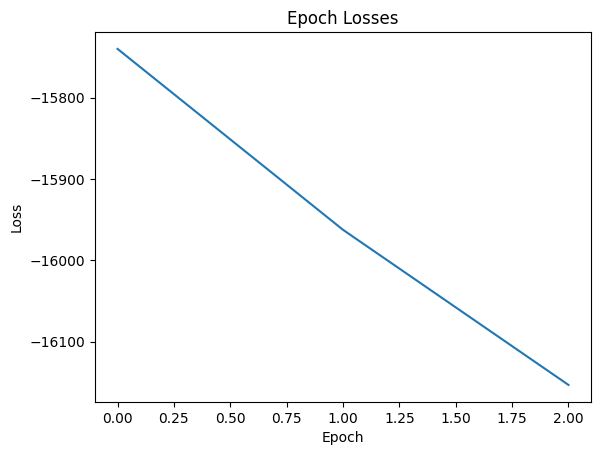

In [39]:
import matplotlib.pyplot as plt

# Create a line plot of the epoch losses
print(training_losses)
plt.plot(training_losses)

# Add labels and a title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epoch Losses')

# Display the plot
plt.show()

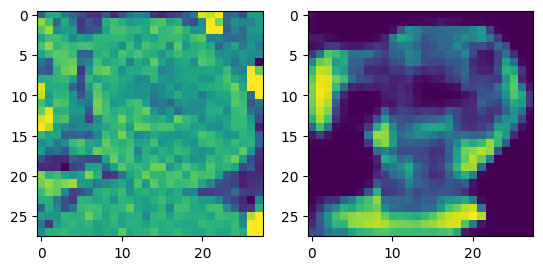

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import random

vae.eval()
with torch.no_grad():
    for data in random.sample(list(test_loader), 1):
        imgs, _ = data
        imgs = imgs.to(device)
        img = np.transpose(imgs[0].cpu().numpy(), [1,2,0])
        plt.subplot(121)
        plt.imshow(np.squeeze(img))
        out, mu, logVAR = vae(imgs)
        outimg = np.transpose(out[0].cpu().numpy(), [1,2,0])
        plt.subplot(122)
        plt.imshow(np.squeeze(outimg))